## Toy Regression Problem

### Dependencies

In [1]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
import posteriors.nuqls as nuqls
import utils
from importlib import reload
import posteriors.swag as swag

torch.set_default_dtype(torch.float64)

### Create toy data

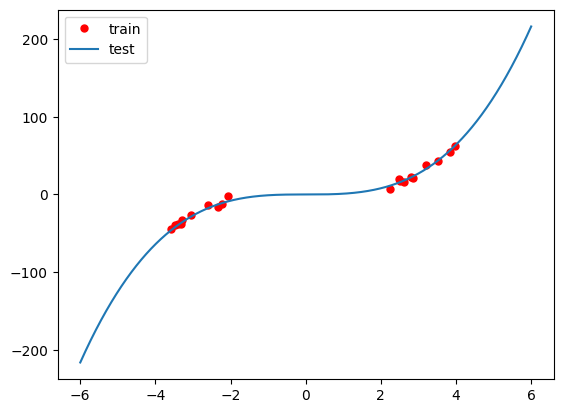

In [2]:
NUM_TRAIN_POINTS = 20
NUM_TEST_POINTS = 10000
std = 3
a1,a2,b1,b2 = -4,-2,2,4
c1,c2 = -6,6
eps = torch.randn((NUM_TRAIN_POINTS),1)*std
train_x = torch.cat((
    torch.rand((int(NUM_TRAIN_POINTS/2),1)) * (a2-a1) + a1,
    torch.rand((int(NUM_TRAIN_POINTS/2),1)) * (b2-b1) + b1
),dim=0)
train_y = torch.pow(train_x,3) + eps

train_y_std = train_y.std()
train_y_mean = train_y.mean()

test_x = torch.linspace(c1,c2,NUM_TEST_POINTS).reshape(-1,1)
test_y = torch.pow(test_x,3).reshape(-1,1)

## plot train
plt.plot(train_x.cpu().numpy().reshape(-1),train_y.cpu().numpy().reshape(-1),'ro',markersize=5,label='train')
plt.plot(test_x.cpu().numpy().reshape(-1),test_y.cpu().numpy().reshape(-1),label='test')
plt.legend()
plt.show()

In [3]:
class toy_dataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
toy_train_loader = DataLoader(toy_dataset(train_x,train_y),NUM_TRAIN_POINTS)
toy_test_loader = DataLoader(toy_dataset(test_x,test_y),NUM_TEST_POINTS)

Using cpu device


  9%|▊         | 865/10000 [00:00<00:02, 4221.45it/s]

Train loss = 1053.1059275189884


 13%|█▎        | 1287/10000 [00:00<00:02, 4193.19it/s]

Train loss = 116.43430161563342


 27%|██▋       | 2655/10000 [00:00<00:01, 4143.78it/s]

Train loss = 94.22923498444128


 35%|███▍      | 3487/10000 [00:00<00:01, 4128.40it/s]

Train loss = 46.678180565986885


 44%|████▎     | 4357/10000 [00:01<00:01, 4084.51it/s]

Train loss = 11.269206613651422


 56%|█████▌    | 5581/10000 [00:01<00:01, 4000.41it/s]

Train loss = 7.4373027367135025


 64%|██████▍   | 6428/10000 [00:01<00:00, 4018.39it/s]

Train loss = 7.355100206712509


 77%|███████▋  | 7656/10000 [00:01<00:00, 4062.62it/s]

Train loss = 7.266226656427098


 85%|████████▌ | 8540/10000 [00:02<00:00, 4092.90it/s]

Train loss = 7.194586017311932


 94%|█████████▎| 9351/10000 [00:02<00:00, 3967.81it/s]

Train loss = 7.133843243060315


100%|██████████| 10000/10000 [00:02<00:00, 4067.51it/s]


Done!


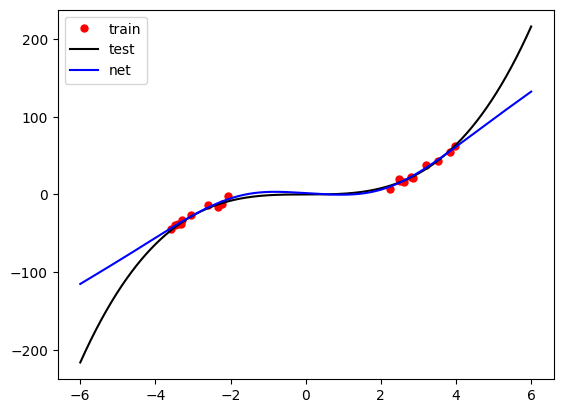

In [6]:
# Get cpu, gpu or mps device for training.
import utils.training


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

## Set up neural network.
width = 50

class oneLayerMLP(torch.nn.Module):
    def __init__(self, width):
        super().__init__()
        self.output_size = 1
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, width),
            torch.nn.SiLU(),
            torch.nn.Linear(width, 1)
        )

    def forward(self, x):
        output = self.net(x)
        return output
    

## MSE Model
map_net = oneLayerMLP(width).to(device)
map_net.apply(utils.training.weights_init_ff)

map_epochs = 10000
map_lr = 0.001
map_wd = 0

mse_loss = torch.nn.MSELoss()
optimizer_MSE = torch.optim.Adam(map_net.parameters(), lr = map_lr, weight_decay=map_wd)
scheduler_MSE = torch.optim.lr_scheduler.PolynomialLR(optimizer_MSE, map_epochs, 0.5)

## Training loop
def train(X, y, model, loss_fn, optimizer, scheduler):
    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()

    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    return loss.item()

def test(X, y, model, loss_fn):
    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    return loss.item()

train_MSE = True
if train_MSE:
    for t in tqdm(range(map_epochs)):
        train_loss = train(train_x, train_y, map_net, mse_loss, optimizer_MSE, scheduler_MSE)
        if t % (map_epochs / 10) == 0:
            print("Train loss = {}".format(train_loss))
    print("Done!")

## plot train
plt.plot(train_x.cpu().numpy().reshape(-1),train_y.cpu().numpy().reshape(-1),'ro',markersize=5,label='train')
plt.plot(test_x.cpu().numpy().reshape(-1),test_y.cpu().numpy().reshape(-1),'k',label='test')
plt.plot(test_x.cpu().numpy().reshape(-1), map_net(test_x).detach().cpu().numpy().reshape(-1), 'b', label='net')
plt.legend()
plt.show()

In [5]:
reload(nuqls)

train_data = toy_dataset(train_x,train_y)
test_data = toy_dataset(test_x,test_y)

nuql_test_preds, res = nuqls.linear_sampling(map_net, train_data, test_data, ood_test_data=None, 
                                             regression= 'True', train_bs = 100, test_bs = 100, 
                                             S = 10, scale=5, lr=1e-3, epochs=1000, mu=0.9, 
                                             verbose=False)
nuql_mu = nuql_test_preds.mean(0)
nuql_var = nuql_test_preds.var(0)
print(res)

C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:101: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional_with_buffers is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional_with_buffers', 'torch.func.functional_call')
100%|██████████| 10/10 [00:08<00:00,  1.25it/s]

{'loss': tensor(5.0853, grad_fn=<DivBackward0>), 'acc': 0}


In [6]:
## Deep Ensemble - Heteroskedastic Variance
WIDTH = width

def to_np(x):
    return x.cpu().detach().numpy()

class EnsembleNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(1,WIDTH)
        self.relu = torch.nn.SiLU()
        self.linear_mu = torch.nn.Linear(WIDTH,1)
        self.linear_sig = torch.nn.Linear(WIDTH,1)

    def forward(self, x):
        x = self.relu(self.linear_1(x))
        mu = self.linear_mu(x)
        variance = self.linear_sig(x)
        variance = torch.nn.functional.softplus(variance) + 1e-6
        return mu, variance

class CustomNLL(torch.nn.Module):
    def __init__(self):
        super(CustomNLL, self).__init__()

    def forward(self, y, mean, var):
        
        loss = (0.5*torch.log(var) + 0.5*(y - mean).pow(2)/var).mean() + 1

        if np.any(np.isnan(to_np(loss))):
            print(torch.log(var))
            print((y - mean).pow(2)/var)
            raise ValueError('There is Nan in loss')
        
        return loss

M = 10
de_lr = 0.05
de_epochs = 5000
de_wd = 0

model_list = []
opt_list = []
sched_list = []

for i in range(M):
    model_list.append(EnsembleNetwork().to(device))
    model_list[i].apply(utils.training.weights_init_ff)
    opt_list.append(torch.optim.Adam(model_list[i].parameters(), lr = de_lr, weight_decay=de_wd))
    sched_list.append(torch.optim.lr_scheduler.PolynomialLR(opt_list[i], de_epochs, 0.5))

NLL = CustomNLL()

def train_heteroskedastic(X,y,net,loss,optim,sched):
    # Compute prediction error
    pred, var = net(X)
    loss = loss(y, pred, var)

    # Backpropagation
    loss.backward()

    optim.step()
    # sched.step()
    optim.zero_grad()

    return loss.item()

train_ensembles = True
if train_ensembles:
    for i in range(M):
        print("\nTraining model {}".format(i))
        for t in range(de_epochs):
            train_loss = train_heteroskedastic(train_x, train_y, model_list[i], NLL, opt_list[i], sched_list[i])
            if t % (de_epochs / 10) == 0:
                print("NLL loss = {}".format(train_loss))
                test_pred,test_var = model_list[i](train_x)
                mle_loss = mse_loss(test_pred,train_y)
                print("MSE loss = {}".format(mle_loss))
        print("Done!")

ensemble_het_mu = torch.empty((M,NUM_TEST_POINTS))
ensemble_het_var = torch.empty((M,NUM_TEST_POINTS))
for i in range(M):
    mu, var = model_list[i](test_x)
    ensemble_het_mu[i,:] = mu.reshape(1,-1)
    ensemble_het_var[i,:] = var.reshape(1,-1)
ensemble_het_mu_mean = torch.mean(ensemble_het_mu,dim=0)
ensemble_het_var_mean = torch.mean(ensemble_het_var + torch.square(ensemble_het_mu), dim=0) - torch.square(ensemble_het_mu_mean)


Training model 0
NLL loss = 1625.6540600403262
MSE loss = 1564.1677188210322
NLL loss = 3.668651056930579
MSE loss = 60.630928539485886
NLL loss = 2.74945695981653
MSE loss = 6.0326981800288415
NLL loss = 2.3554878551087417
MSE loss = 4.035993612319883
NLL loss = 2.1600069632453143
MSE loss = 3.733949328421128
NLL loss = 2.0431994381870893
MSE loss = 3.705970651804953
NLL loss = 1.9444754316057733
MSE loss = 3.7049130283914513
NLL loss = 1.9306717448387702
MSE loss = 3.703218089056888
NLL loss = 2.2240679143655457
MSE loss = 3.6149432869383658
NLL loss = 1.938669570194116
MSE loss = 3.593611906268749
Done!

Training model 1
NLL loss = 1770.9726255571954
MSE loss = 1579.045699153415
NLL loss = 4.291482741507803
MSE loss = 100.48358518769469
NLL loss = 2.8380282789481592
MSE loss = 7.489046250990391
NLL loss = 2.4283401085449894
MSE loss = 4.496167405716461
NLL loss = 2.2024739317599185
MSE loss = 4.124692527781541
NLL loss = 2.044477276419319
MSE loss = 3.9366481716405275
NLL loss = 1.

In [8]:
reload(swag)

swag_net = oneLayerMLP(width).to(device)
swag_net.apply(utils.training.weights_init_ff)

optimizer_MSE = torch.optim.Adam(swag_net.parameters(), lr = map_lr, weight_decay=map_wd)
scheduler_MSE = torch.optim.lr_scheduler.PolynomialLR(optimizer_MSE, map_epochs, 0.5)

for t in tqdm(range(map_epochs)):
    train_loss = train(train_x, train_y, swag_net, mse_loss, optimizer_MSE, scheduler_MSE)
    if t % (map_epochs / 10) == 0:
        print("Train loss = {}".format(train_loss))
print("Done!")

swag_method = swag.SWAG_R(swag_net,epochs = map_epochs, lr = map_lr, cov_mat = True,
                            max_num_models=10)
swag_method.train_swag(train_x,train_y)

T = 1000
swag_pred_samples = torch.empty((T,NUM_TEST_POINTS),device='cpu')
for t in range(T):
    swag_method.sample(cov=True)
    swag_pred_samples[t,:] = swag_method(test_x).reshape(-1)
swag_pred = swag_pred_samples.mean(axis=0)
swag_var = swag_pred_samples.var(axis=0)

  9%|▉         | 889/10000 [00:00<00:02, 4199.51it/s]

Train loss = 1019.9243377718892


 18%|█▊        | 1753/10000 [00:00<00:02, 4043.46it/s]

Train loss = 109.34691407397057


 26%|██▌       | 2590/10000 [00:00<00:01, 4112.93it/s]

Train loss = 74.75564889689755


 38%|███▊      | 3820/10000 [00:00<00:01, 3999.08it/s]

Train loss = 35.21309954776897


 46%|████▋     | 4641/10000 [00:01<00:01, 3986.95it/s]

Train loss = 13.133238031042078


 55%|█████▍    | 5493/10000 [00:01<00:01, 3980.06it/s]

Train loss = 8.129773438431858


 68%|██████▊   | 6817/10000 [00:01<00:00, 4126.54it/s]

Train loss = 7.689505284656301


 76%|███████▋  | 7640/10000 [00:01<00:00, 4092.65it/s]

Train loss = 7.374206165421934


 85%|████████▍ | 8455/10000 [00:02<00:00, 3954.08it/s]

Train loss = 7.172622443499352


 98%|█████████▊| 9776/10000 [00:02<00:00, 4089.78it/s]

Train loss = 7.065571684057727


100%|██████████| 10000/10000 [00:02<00:00, 4051.73it/s]


Done!


In [10]:
from posteriors.lla.likelihoods import GaussianLh
from posteriors.lla.laplace import Laplace

prior_prec = 0.1
lh = GaussianLh(sigma_noise=3)  # fixed to true noise

lap = Laplace(map_net, float(prior_prec), lh)


def get_pred_for(model_type='glm', cov_type='full'):
    #### INFERENCE (Posterior approximation) ####
    lap.infer(toy_train_loader, cov_type=cov_type, dampen_kron=model_type=='bnn')
    if model_type == 'glm':
        #### GLM PREDICTIVE ####
        mu, var = lap.predictive_samples_glm(test_x, n_samples=1000)
    elif model_type == 'bnn':
        #### BNN PREDICTIVE ####
        samples = lap.predictive_samples_bnn(test_x, n_samples=1000)
        mu, var = samples.mean(dim=0), samples.var(dim=0)
    else:
        raise ValueError('unsupported model_type.')
    # mu = mu.detach().cpu().squeeze().numpy()
    # var = var.detach().cpu().squeeze().numpy()
    return mu.reshape(-1,1), var.reshape(-1,1)

# LLA
mu_glm_full, var_glm_full = get_pred_for('glm', 'full')



C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\backpack\extensions\backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.oneLayerMLP'> although the module has parameters
  warnings.warn(


In [11]:
prior_prec = 1
lh = GaussianLh(sigma_noise=3)  # fixed to true noise

lap = Laplace(map_net, float(prior_prec), lh)


def get_pred_for(model_type='glm', cov_type='full'):
    #### INFERENCE (Posterior approximation) ####
    lap.infer(toy_train_loader, cov_type=cov_type, dampen_kron=model_type=='bnn')
    if model_type == 'glm':
        #### GLM PREDICTIVE ####
        mu, var = lap.predictive_samples_glm(test_x, n_samples=1000)
    elif model_type == 'bnn':
        #### BNN PREDICTIVE ####
        samples = lap.predictive_samples_bnn(test_x, n_samples=1000)
        mu, var = samples.mean(dim=0), samples.var(dim=0)
    else:
        raise ValueError('unsupported model_type.')
    # mu = mu.detach().cpu().squeeze().numpy()
    # var = var.detach().cpu().squeeze().numpy()
    return mu.reshape(-1,1), var.reshape(-1,1)

# LA
mu_bnn_full, var_bnn_full = get_pred_for('bnn', 'full')

In [12]:
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss
from copy import deepcopy

const_bnn_prior_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 3.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": False,  # True to initialize mu/sigma from the pretrained dnn weights
        "moped_delta": 1,
}

vi_net = deepcopy(map_net)
    
dnn_to_bnn(vi_net, const_bnn_prior_parameters)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(vi_net.parameters(), 1e-3, weight_decay=0)

for _ in range(10000):
    output = vi_net(train_x)
    kl = get_kl_loss(vi_net)
    ce_loss = criterion(output, train_y)
    loss = ce_loss + kl

    loss.backward()
    optimizer.step()
    print(f"loss = {loss}")

vi_net.eval()
with torch.no_grad():
    output_mc = []
    for mc_run in range(1000):
        output = vi_net(test_x)
        output_mc.append(output)
    output = torch.stack(output_mc)  
    mu_vi = output.mean(0)
    var_vi = output.var(0)


loss = 1680.7484856106096
loss = 1677.2232415055257
loss = 1679.1342515104304
loss = 1677.9299398023934
loss = 1679.0532339673637
loss = 1681.3318576008598
loss = 1674.0358089884144
loss = 1670.5157861141504
loss = 1667.696678143291
loss = 1668.9688159271898
loss = 1662.6478819867352
loss = 1676.696522383261
loss = 1672.0334803857158
loss = 1668.9030215635614
loss = 1655.1203204754706
loss = 1666.5954571209863
loss = 1660.410564647548
loss = 1668.1593370874934
loss = 1658.7523577321406
loss = 1659.6214503776646
loss = 1658.263087762685
loss = 1661.6525948241228
loss = 1665.0934475523438
loss = 1664.1018254240503
loss = 1666.6687938590876
loss = 1651.903363124915
loss = 1660.5709296993277
loss = 1666.9627657997507
loss = 1654.2327502888402
loss = 1658.312724270923
loss = 1653.4319399389199
loss = 1654.5311780278225
loss = 1642.1140744585857
loss = 1636.5528513977372
loss = 1645.6447836531215
loss = 1638.8222192883507
loss = 1636.300817547065
loss = 1640.089909095246
loss = 1640.56407953

In [13]:
## Plot
def plot_torch(x):
    return x.detach().cpu().numpy().reshape(-1)

def plot_bayes_method(ax,mean,var,title,fs,ms,lw):
    ax.plot(plot_torch(train_x),plot_torch(train_y),'ro',markersize=ms)
    ax.plot(plot_torch(test_x),plot_torch(test_y),'k',linewidth=lw)
    ax.plot(plot_torch(test_x),plot_torch(mean),'b',linewidth=lw)

    ci = torch.sqrt(var)*3
    y1, y2 = mean - ci, mean + ci

    ax.fill_between(plot_torch(test_x), plot_torch(y1), plot_torch(y2), color='g', alpha=.4)

    ax.set_title(title, fontsize=fs)
    ax.set_yticks(np.array((-200,0,200)))
    ax.set_ylim([-300,300])
    ax.tick_params(axis='both', which='major', labelsize=fs)


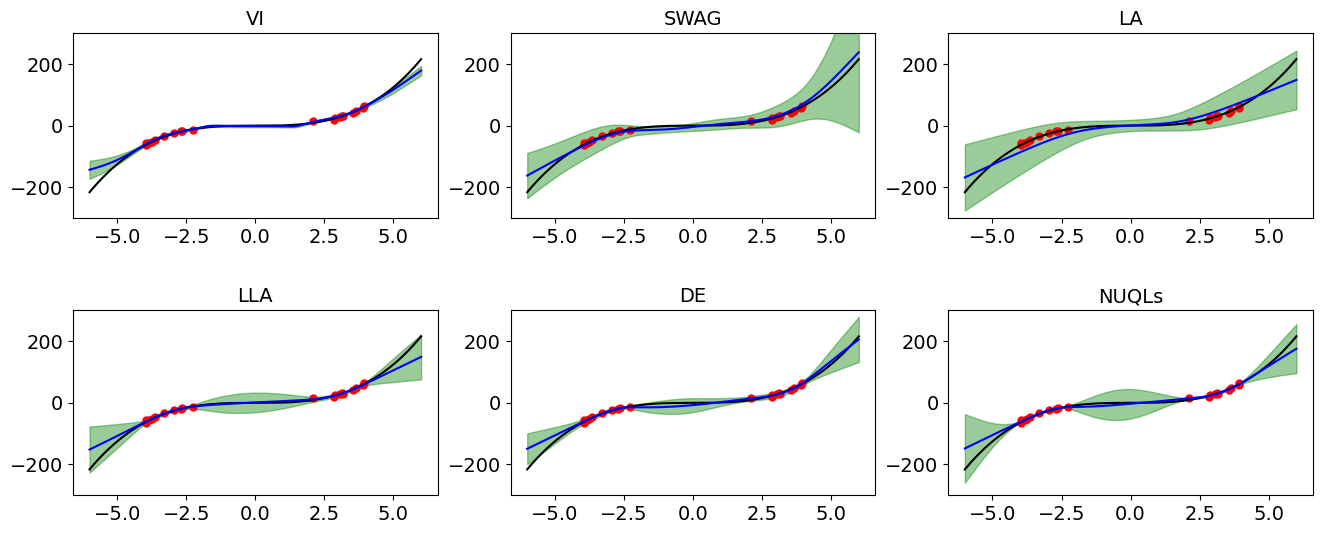

In [14]:
fs, ms, lw = 14, 5, 1.5

# plt.rc('xtick', labelsize=10) 
# plt.rc('ytick', labelsize=10) 

f, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3)

f.set_figheight(6)
f.set_figwidth(16)
f.subplots_adjust(hspace=0.5)

## Plot VI
plot_bayes_method(ax1,mu_vi,var_vi,'VI',fs=fs, ms=ms, lw=lw)

## Plot SWAG
plot_bayes_method(ax2,swag_pred,swag_var,'SWAG',fs=fs, ms=ms, lw=lw)

## LA
plot_bayes_method(ax3,mu_bnn_full,var_bnn_full,'LA',fs=fs, ms=ms, lw=lw)

## Plot LLA
plot_bayes_method(ax4,mu_glm_full,var_glm_full,'LLA',fs=fs, ms=ms, lw=lw)

## Plot DE
plot_bayes_method(ax5,ensemble_het_mu_mean,ensemble_het_var_mean,'DE',fs=fs, ms=ms, lw=lw)

## Plot NUQLs
plot_bayes_method(ax6,nuql_mu,nuql_var,'NUQLs',fs=fs, ms=ms, lw=lw)

plt.savefig("UncertaintyComparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [15]:
from functorch import make_functional
from torch.func import vmap, jacrev

def l_layer_params(net):
    theta_star_k = []
    sd = net.state_dict()
    sdk = sd.keys()
    print(len(sdk))
    for i,p in enumerate(sdk):
        if i < len(sdk) - 2:
            theta_star_k.append(sd[p].flatten(0))
        else:
            theta_star_k.append(torch.zeros(sd[p].flatten(0).shape))
    theta_star_k = torch.cat(theta_star_k)
    return theta_star_k

def flatten(lst):
    tmp = [i.contiguous().view(-1, 1) for i in lst]
    return torch.cat(tmp).view(-1)

M = 10
learning_rate = 0.01
epochs = 10000
weight_decay = 0
sigma2 = std**2

model_list = []
opt_list = []
sched_list = []

loss = mse_loss
bde_preds = torch.empty((M,NUM_TEST_POINTS))

def train_bde(X,y,net,delta,theta_k,loss,Lambda,optim,sched):
    # Compute prediction error
    pred = net(X)

    # Add delta function to outputs
    pred = pred + delta

    # Calculate loss
    loss = loss(y, pred)

    # Regularisation
    theta_t = torch.nn.utils.parameters_to_vector(net.parameters())
    diff = theta_t - theta_k
    reg = diff @ (Lambda * diff)
    loss = 0.5 * loss + 0.5 * reg

    # Backpropagation
    loss.backward()

    optim.step()
    if sched is not None:
        sched.step()
    optim.zero_grad()

    return loss.item()

def bde_weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.normal_(m.bias,mean=0,std=1)

for i in range(M):
    bde_model1 = oneLayerMLP(width).to(device)
    bde_model1.apply(bde_weights_init)
    opt = torch.optim.Adam(bde_model1.parameters(), lr = map_lr, weight_decay=map_wd)
    sched = torch.optim.lr_scheduler.PolynomialLR(opt, map_epochs, 0.5)

    ## Find theta~
    bde_model2 = oneLayerMLP(width).to(device)
    bde_model2.apply(utils.training.weights_init_ff) 
    theta_star_k = l_layer_params(bde_model2)

    ## Create delta functions
    fnet, params = make_functional(bde_model1)
    def jacobian(x):
        def fnet_single(params, x):
            return fnet(params, x.unsqueeze(0)).squeeze(0)
        J = vmap(jacrev(fnet_single), (None, 0))(params, x.to(device))
        J = [j.detach().flatten(1) for j in J]
        J = torch.cat(J,dim=1).detach()
        return J
    delta = lambda x : jacobian(x) @ theta_star_k
    train_delta = delta(train_x)

    ## Save theta_k
    theta_k = torch.nn.utils.parameters_to_vector(bde_model1.parameters()).detach().clone()

    ## Create Mahalanobis matrix
    Lambda = 1 / sigma2

    ## Train ensemble member
    print("\nTraining model {}".format(i))
    for t in tqdm(range(map_epochs)):
        train_loss = train_bde(train_x, train_y, bde_model1, train_delta, theta_k, mse_loss, Lambda, opt, sched)
        if t % (epochs / 10) == 0:
            print("train loss = {:.4f}".format(train_loss))
    print("Done!")

    # Get predictions
    bde_pred = bde_model1(test_x).reshape(-1) + delta(test_x).reshape(-1)
    bde_preds[i,:] = bde_pred

bde_mean = torch.mean(bde_preds,dim=0)
bde_var = torch.var(bde_preds,dim=0) # + std**2

C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')


6

Training model 0


  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20, 20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 121/10000 [00:00<00:08, 1204.94it/s]

train loss = 839.4053


 12%|█▏        | 1240/10000 [00:00<00:06, 1374.09it/s]

train loss = 16.1873


 22%|██▏       | 2228/10000 [00:01<00:05, 1382.09it/s]

train loss = 8.9911


 32%|███▏      | 3219/10000 [00:02<00:04, 1386.88it/s]

train loss = 7.1407


 42%|████▏     | 4230/10000 [00:03<00:04, 1385.29it/s]

train loss = 6.2429


 52%|█████▏    | 5215/10000 [00:03<00:03, 1379.41it/s]

train loss = 5.7860


 62%|██████▏   | 6206/10000 [00:04<00:02, 1320.68it/s]

train loss = 5.5238


 72%|███████▏  | 7196/10000 [00:05<00:02, 1381.92it/s]

train loss = 5.3370


 82%|████████▏ | 8188/10000 [00:05<00:01, 1390.64it/s]

train loss = 5.2231


 92%|█████████▏| 9191/10000 [00:06<00:00, 1373.90it/s]

train loss = 5.1576


100%|██████████| 10000/10000 [00:07<00:00, 1369.85it/s]


Done!
6

Training model 1


  0%|          | 0/10000 [00:00<?, ?it/s]

train loss = 826.2341


 12%|█▏        | 1236/10000 [00:00<00:06, 1362.95it/s]

train loss = 15.5648


 22%|██▏       | 2195/10000 [00:01<00:05, 1367.49it/s]

train loss = 9.5154


 32%|███▏      | 3157/10000 [00:02<00:05, 1348.41it/s]

train loss = 7.2368


 42%|████▏     | 4154/10000 [00:03<00:04, 1355.95it/s]

train loss = 6.6095


 52%|█████▏    | 5230/10000 [00:03<00:03, 1328.49it/s]

train loss = 6.2637


 61%|██████    | 6098/10000 [00:04<00:02, 1369.56it/s]

train loss = 6.0064


 72%|███████▏  | 7220/10000 [00:05<00:02, 1375.22it/s]

train loss = 5.8233


 82%|████████▏ | 8200/10000 [00:06<00:01, 1375.51it/s]

train loss = 5.6829


 92%|█████████▏| 9184/10000 [00:06<00:00, 1374.50it/s]

train loss = 5.5487


100%|██████████| 10000/10000 [00:07<00:00, 1350.35it/s]


Done!
6

Training model 2


  0%|          | 0/10000 [00:00<?, ?it/s]

train loss = 831.4990


 11%|█         | 1118/10000 [00:00<00:06, 1350.43it/s]

train loss = 15.7527


 22%|██▏       | 2224/10000 [00:01<00:05, 1382.68it/s]

train loss = 8.7656


 32%|███▏      | 3206/10000 [00:02<00:04, 1374.32it/s]

train loss = 7.2732


 42%|████▏     | 4185/10000 [00:03<00:04, 1323.25it/s]

train loss = 6.6619


 52%|█████▏    | 5158/10000 [00:03<00:03, 1368.93it/s]

train loss = 6.3337


 62%|██████▏   | 6159/10000 [00:04<00:02, 1372.61it/s]

train loss = 6.0901


 71%|███████▏  | 7146/10000 [00:05<00:02, 1379.33it/s]

train loss = 5.9245


 81%|████████▏ | 8131/10000 [00:05<00:01, 1376.39it/s]

train loss = 5.7773


 91%|█████████ | 9106/10000 [00:06<00:00, 1350.10it/s]

train loss = 5.6472


100%|██████████| 10000/10000 [00:07<00:00, 1355.96it/s]


Done!
6

Training model 3


  0%|          | 0/10000 [00:00<?, ?it/s]

train loss = 836.6765


 11%|█▏        | 1133/10000 [00:00<00:06, 1385.85it/s]

train loss = 17.4672


 22%|██▏       | 2243/10000 [00:01<00:05, 1359.78it/s]

train loss = 9.1238


 32%|███▏      | 3222/10000 [00:02<00:05, 1340.31it/s]

train loss = 7.4971


 42%|████▏     | 4216/10000 [00:03<00:04, 1388.48it/s]

train loss = 6.6194


 52%|█████▏    | 5210/10000 [00:03<00:03, 1393.92it/s]

train loss = 6.0821


 62%|██████▏   | 6202/10000 [00:04<00:02, 1387.58it/s]

train loss = 5.7844


 72%|███████▏  | 7179/10000 [00:05<00:02, 1312.40it/s]

train loss = 5.5877


 83%|████████▎ | 8275/10000 [00:06<00:01, 1371.27it/s]

train loss = 5.4389


 91%|█████████ | 9103/10000 [00:06<00:00, 1377.59it/s]

train loss = 5.3554


100%|██████████| 10000/10000 [00:07<00:00, 1364.69it/s]


Done!
6

Training model 4


  0%|          | 0/10000 [00:00<?, ?it/s]

train loss = 843.1762


 12%|█▏        | 1237/10000 [00:00<00:06, 1313.22it/s]

train loss = 18.6710


 22%|██▏       | 2201/10000 [00:01<00:05, 1366.76it/s]

train loss = 8.7564


 32%|███▏      | 3192/10000 [00:02<00:05, 1354.86it/s]

train loss = 7.4688


 42%|████▏     | 4193/10000 [00:03<00:04, 1370.69it/s]

train loss = 6.8947


 52%|█████▏    | 5179/10000 [00:03<00:03, 1372.02it/s]

train loss = 6.5498


 63%|██████▎   | 6261/10000 [00:04<00:02, 1352.38it/s]

train loss = 6.2735


 72%|███████▏  | 7240/10000 [00:05<00:02, 1366.17it/s]

train loss = 6.1206


 82%|████████▏ | 8215/10000 [00:06<00:01, 1365.64it/s]

train loss = 5.9950


 92%|█████████▏| 9174/10000 [00:06<00:00, 1295.39it/s]

train loss = 5.8673


100%|██████████| 10000/10000 [00:07<00:00, 1347.61it/s]


Done!
6

Training model 5


  0%|          | 0/10000 [00:00<?, ?it/s]

train loss = 815.5911


 12%|█▏        | 1213/10000 [00:00<00:06, 1350.02it/s]

train loss = 16.0604


 22%|██▏       | 2186/10000 [00:01<00:05, 1357.36it/s]

train loss = 8.1721


 32%|███▏      | 3164/10000 [00:02<00:05, 1322.22it/s]

train loss = 6.6207


 41%|████▏     | 4145/10000 [00:03<00:04, 1364.38it/s]

train loss = 6.0191


 51%|█████▏    | 5140/10000 [00:03<00:03, 1358.31it/s]

train loss = 5.7862


 61%|██████    | 6121/10000 [00:04<00:02, 1371.09it/s]

train loss = 5.6017


 71%|███████   | 7107/10000 [00:05<00:02, 1374.45it/s]

train loss = 5.3474


 82%|████████▏ | 8193/10000 [00:06<00:01, 1339.02it/s]

train loss = 5.1895


 92%|█████████▏| 9153/10000 [00:06<00:00, 1356.31it/s]

train loss = 5.0926


100%|██████████| 10000/10000 [00:07<00:00, 1344.32it/s]


Done!
6

Training model 6


  0%|          | 0/10000 [00:00<?, ?it/s]

train loss = 836.7024


 12%|█▏        | 1233/10000 [00:00<00:06, 1358.19it/s]

train loss = 13.7830


 22%|██▏       | 2189/10000 [00:01<00:05, 1332.66it/s]

train loss = 8.2548


 32%|███▏      | 3176/10000 [00:02<00:04, 1375.04it/s]

train loss = 6.4808


 42%|████▏     | 4155/10000 [00:03<00:04, 1368.29it/s]

train loss = 5.7506


 51%|█████▏    | 5145/10000 [00:03<00:03, 1384.65it/s]

train loss = 5.4277


 62%|██████▏   | 6249/10000 [00:04<00:02, 1315.11it/s]

train loss = 5.2996


 72%|███████▏  | 7231/10000 [00:05<00:02, 1366.49it/s]

train loss = 5.2353


 82%|████████▏ | 8210/10000 [00:06<00:01, 1372.22it/s]

train loss = 5.1894


 92%|█████████▏| 9191/10000 [00:06<00:00, 1372.80it/s]

train loss = 5.1557


100%|██████████| 10000/10000 [00:07<00:00, 1353.44it/s]


Done!
6

Training model 7


  1%|          | 106/10000 [00:00<00:09, 1053.18it/s]

train loss = 819.9818


 12%|█▏        | 1197/10000 [00:00<00:06, 1363.60it/s]

train loss = 16.1135


 22%|██▏       | 2172/10000 [00:01<00:05, 1363.57it/s]

train loss = 10.8132


 31%|███▏      | 3148/10000 [00:02<00:05, 1367.23it/s]

train loss = 9.0476


 41%|████▏     | 4146/10000 [00:03<00:04, 1358.93it/s]

train loss = 7.9957


 53%|█████▎    | 5258/10000 [00:03<00:03, 1352.45it/s]

train loss = 7.4594


 62%|██████▏   | 6243/10000 [00:04<00:02, 1368.80it/s]

train loss = 7.2071


 71%|███████   | 7086/10000 [00:05<00:02, 1371.16it/s]

train loss = 7.0827


 81%|████████  | 8087/10000 [00:05<00:01, 1364.39it/s]

train loss = 6.9512


 92%|█████████▏| 9212/10000 [00:06<00:00, 1346.01it/s]

train loss = 6.6526


100%|██████████| 10000/10000 [00:07<00:00, 1350.19it/s]


Done!
6

Training model 8


  0%|          | 0/10000 [00:00<?, ?it/s]

train loss = 822.5526


 12%|█▏        | 1225/10000 [00:00<00:06, 1356.69it/s]

train loss = 20.5452


 22%|██▏       | 2198/10000 [00:01<00:05, 1363.59it/s]

train loss = 8.2834


 32%|███▏      | 3180/10000 [00:02<00:04, 1378.80it/s]

train loss = 6.7128


 42%|████▏     | 4151/10000 [00:03<00:04, 1362.48it/s]

train loss = 6.0491


 51%|█████     | 5122/10000 [00:03<00:03, 1349.73it/s]

train loss = 5.6453


 62%|██████▏   | 6235/10000 [00:04<00:02, 1304.30it/s]

train loss = 5.4663


 72%|███████▏  | 7192/10000 [00:05<00:02, 1338.57it/s]

train loss = 5.3456


 82%|████████▏ | 8173/10000 [00:06<00:01, 1325.17it/s]

train loss = 5.2603


 93%|█████████▎| 9269/10000 [00:06<00:00, 1366.69it/s]

train loss = 5.2225


100%|██████████| 10000/10000 [00:07<00:00, 1340.94it/s]


Done!
6

Training model 9


  0%|          | 0/10000 [00:00<?, ?it/s]

train loss = 860.9387


 13%|█▎        | 1255/10000 [00:00<00:06, 1365.69it/s]

train loss = 14.6181


 22%|██▏       | 2190/10000 [00:01<00:05, 1307.19it/s]

train loss = 9.7244


 32%|███▏      | 3185/10000 [00:02<00:05, 1362.97it/s]

train loss = 8.1452


 42%|████▏     | 4168/10000 [00:03<00:04, 1374.34it/s]

train loss = 7.1260


 51%|█████▏    | 5136/10000 [00:03<00:03, 1376.18it/s]

train loss = 6.6163


 62%|██████▎   | 6250/10000 [00:04<00:02, 1376.21it/s]

train loss = 6.2726


 72%|███████▏  | 7213/10000 [00:05<00:02, 1365.09it/s]

train loss = 5.9980


 82%|████████▏ | 8220/10000 [00:06<00:01, 1375.81it/s]

train loss = 5.7693


 92%|█████████▏| 9198/10000 [00:06<00:00, 1367.48it/s]

train loss = 5.6230


100%|██████████| 10000/10000 [00:07<00:00, 1356.88it/s]


Done!


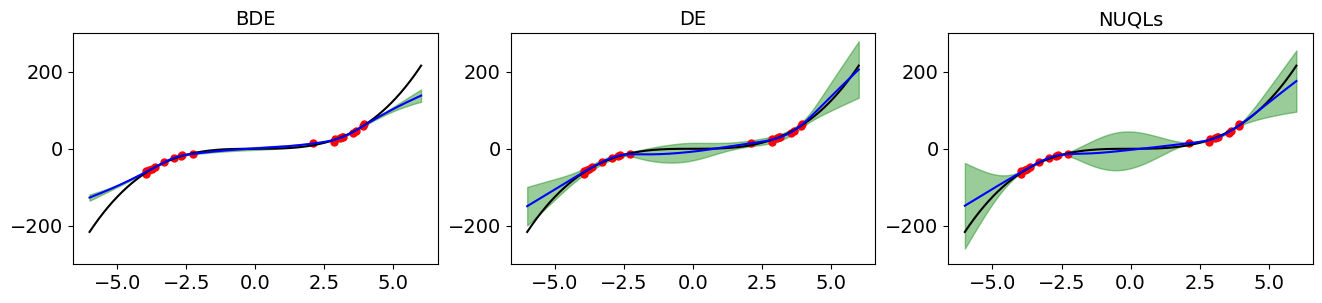

In [16]:
fs, ms, lw = 14, 5, 1.5

# plt.rc('xtick', labelsize=10) 
# plt.rc('ytick', labelsize=10) 

f, (ax1,ax2,ax3) = plt.subplots(1,3)

f.set_figheight(3)
f.set_figwidth(16)
f.subplots_adjust(hspace=0.5)

## Plot BDE
plot_bayes_method(ax1,bde_mean,bde_var,'BDE',fs=fs, ms=ms, lw=lw)

## Plot DE
plot_bayes_method(ax2,ensemble_het_mu_mean,ensemble_het_var_mean,'DE',fs=fs, ms=ms, lw=lw)

## Plot NUQLs
plot_bayes_method(ax3,nuql_mu,nuql_var,'NUQLs',fs=fs, ms=ms, lw=lw)

plt.savefig("UncertaintyComparison_bde.pdf", format="pdf", bbox_inches="tight")
plt.show()